In [1]:
import sys
import copy
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

from naiad.models import EmbedPhenoDataset, EmbedPhenoModel, RecoverModel
from naiad.utils import load_naiad_data, \
                        split_data, \
                        reorganize_single_treatment_effects, \
                        create_lr_scheduler

In [2]:
device = (
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

pd.set_option('mode.chained_assignment', None)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

## Prepare Data

In [3]:
data_path = '../../data/norman/norman_gamma.csv'

pheno_pert_data = load_naiad_data(data_path)

gene_cols = [col for col in pheno_pert_data.columns if re.match(r'id\d$', col)]
all_genes = np.sort(np.unique(pheno_pert_data[gene_cols].values.flatten())).tolist()

In [4]:
def prepare_dataloaders(data, batch_size, genes):
    datasets = {split: EmbedPhenoDataset(data[split], genes) for split in data}
    dataloaders = {split: DataLoader(datasets[split], shuffle = False, batch_size = batch_size) for split in datasets}

    return dataloaders

## Train Model

In [5]:
d_both_pheno = 64
n_epoch = 500
train_both_embed = {0.01: 2,
                    0.05: 4,
                    0.1: 16,
                    0.15: 32,
                    0.2: 32,
                    0.3: 64,
                    0.4: 64,
                    0.5: 64,
                    0.65: 128,
                    0.8: 128}

In [6]:
train_args = {'embed_lr': 1e-2,
              'pheno_lr': 1e-2,
              'weight_decay': 0,
              'n_epoch': None}

In [7]:
def setup_training(all_genes, train_dataloader, model_args, train_args):
    model_type = model_args['model_type']
    weight_decay = train_args['weight_decay']

    n_genes = len(all_genes)
    if model_type == 'recover':
        recover_args = copy.deepcopy(model_args)
        recover_args.pop('model_type')
        model = RecoverModel(n_genes, **recover_args).to(device)
    else:
        model = EmbedPhenoModel(n_genes, **model_args).to(device)

    if model_type == 'pheno':
        pheno_lr = train_args['pheno_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = pheno_lr, weight_decay = weight_decay)
        
    elif model_type == 'embed':
        embed_lr = train_args['embed_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = embed_lr, weight_decay = weight_decay)

    elif model_type == 'both':
        embed_lr = train_args['embed_lr']
        pheno_lr = train_args['pheno_lr']
        pheno_param = model.pheno_ffn.parameters()
        embed_param = [p for p in model.parameters() if p not in set(pheno_param)]
        optimizer = torch.optim.Adam([{'params': pheno_param, 'lr': pheno_lr, 'weight_decay': weight_decay}, 
                                      {'params': embed_param, 'lr': embed_lr, 'weight_decay': weight_decay}])
    
    elif model_type == 'recover':
        embed_lr = train_args['embed_lr']
        optimizer = torch.optim.Adam(model.parameters(), lr = embed_lr, weight_decay = weight_decay)

    n_epoch = train_args['n_epoch']
    n_train_steps = n_epoch * len(train_dataloader)
    lr_scheduler = create_lr_scheduler(optimizer, warmup_steps = int(n_train_steps / 10), total_steps = n_train_steps)

    loss_fn = torch.nn.MSELoss(reduction='sum')

    return model, optimizer, lr_scheduler, loss_fn

In [8]:
def train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch):
    train_dataloader = dataloaders['train']
    val_dataloader = dataloaders['val']
    
    all_train_loss = []
    all_val_loss = []
    min_val_loss = np.inf
    for i in tqdm(range(n_epoch)):
        model.train()
        train_loss = 0
        for inputs, targets, phenos in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(inputs, phenos)
            loss = loss_fn(targets, preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            train_loss += loss

        model.eval()
        val_loss = 0
        for inputs, targets, phenos in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(inputs, phenos)
            loss = loss_fn(targets, preds)

            val_loss += loss
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                best_model = copy.deepcopy(model)

        all_train_loss.append(train_loss.detach().cpu() / dataloaders['train'].dataset.data.shape[0])
        all_val_loss.append(val_loss.detach().cpu() / dataloaders['val'].dataset.data.shape[0])
        
    return model, best_model, all_train_loss, all_val_loss

In [9]:
def generate_predictions(model, dataloaders):
    model.eval()

    all_preds = {}
    for split in dataloaders:
        dataloader = dataloaders[split]
        split_preds = []
        for input, targets, phenos in dataloader:
            input = input.to(device)
            targets = targets.to(device)
            phenos = phenos.to(device)

            preds = model(input, phenos)
            split_preds.extend(preds.detach().cpu().tolist())

        all_preds[split] = split_preds

    return all_preds

In [10]:
def generate_plot(all_train_loss, all_val_loss, train_targets, val_targets, train_preds, val_preds, alpha=1):

    fig, axs = plt.subplots(1, 3, figsize = [14, 4])
    sns.lineplot(np.log(all_train_loss), label = 'Train Loss', ax = axs[0])
    sns.lineplot(np.log(all_val_loss), label = 'Val Loss', ax = axs[0])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('log(Loss)')
    axs[0].set_title('Loss Curves')

    sns.scatterplot(x = train_targets, y = train_preds, ax = axs[1], alpha=alpha)
    axs[1].set_xlabel('Targets')
    axs[1].set_ylabel('Preds')
    axs[1].set_title('Train Targets vs Preds')

    sns.scatterplot(x = val_targets, y = val_preds, ax = axs[2], alpha=alpha)
    axs[2].set_xlabel('Targets')
    axs[2].set_ylabel('Preds')
    axs[2].set_title('Val Targets vs Preds')

    fig.tight_layout()
    return fig


In [11]:
def calculate_tpr(targets, preds, frac):
    # assume targets and preds are in same order in terms of perturbation values
    if len(targets) != len(preds):
        raise ValueError('"targets" and "preds" arguments should have same length.')
    if frac < 1:
        n_top = int(frac * len(targets))
    else:
        n_top = frac
    # target_sort_idx = list(reversed(np.argsort(targets).values))[:n_top]
    # pred_sort_idx = list(reversed(np.argsort(preds)))[:n_top]
    target_sort_idx = list((np.argsort(targets).values))[:n_top]
    pred_sort_idx = list((np.argsort(preds)))[:n_top]

    return len(set(target_sort_idx).intersection(set(pred_sort_idx))) / n_top

In [12]:
def collect_results(results_dict, n_tpr):
    results = {'train_loss': [results_dict['train']['loss']], 
               'val_loss': [results_dict['val']['loss']], 
               'test_loss': [results_dict['test']['loss']],
               'train_corr': [results_dict['train']['corr']], 
               'val_corr': [results_dict['val']['corr']], 
               'test_corr': [results_dict['test']['corr']]}
    
    for split in results_dict:
        for tpr in n_tpr:
            results[f'{split}_tpr{tpr}'] = [results_dict[split][f'tpr{tpr}']]

    return results

In [13]:
train_args['n_epoch'] = n_epoch
n_tpr = [25, 50, 100, 150, 200, 300]
results = {}
batch_size = 1024
alpha = 1
plot = False

d_phenos = [64]
d_embeds = [128]
d_recover_embeds = [128]
d_combined_embeds = [4]

combined_results = pd.DataFrame()

seeds = [748, 808, 210]

for seed in seeds: # random seeds from an RNG
    seed = int(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    np_rng = np.random.default_rng(seed)
    torch_rng = torch.Generator().manual_seed(seed)
    pheno_pert_data_shuffle = pheno_pert_data.sample(frac = 1, random_state = np_rng)

    
    for frac, d_both_embed in train_both_embed.items():
        data = split_data(pheno_pert_data_shuffle, n_train = frac, n_val = 0.1, n_test = 0.1)
        dataloaders = prepare_dataloaders(data, batch_size, all_genes)

        # Train / evaluate linear model
        linear_model = LinearRegression()
        train_features = data['train'][['id1_score', 'id2_score']]
        train_targets = data['train']['comb_score']
        linear_model.fit(train_features, train_targets)

        linear_results = {}
        linear_features = {}
        linear_targets = {}
        linear_preds = {}

        for split in data:
            linear_features[split] = data[split][['id1_score', 'id2_score']]
            linear_targets[split] = data[split]['comb_score']
            linear_preds[split] = linear_model.predict(linear_features[split])

            linear_loss = np.sum((linear_preds[split] - linear_targets[split])**2) / len(linear_preds[split])
            linear_corr = np.corrcoef(linear_preds[split], linear_targets[split])[0][1]
            linear_spearman = scipy.stats.spearmanr(linear_preds[split], linear_targets[split])
            linear_results[split] = {'loss': linear_loss,
                                     'corr': linear_corr}
            for tpr in n_tpr:
                linear_results[split][f'tpr{tpr}'] = calculate_tpr(linear_targets[split], linear_preds[split], tpr)

        if plot:
            fig = generate_plot([linear_results['train']['loss']],
                                [linear_results['val']['loss']],
                                linear_targets['train'], linear_targets['val'],
                                linear_preds['train'], linear_preds['val'],
                                alpha=alpha)
            fig.suptitle(f'Model: Linear, Training Fraction: {frac}', fontsize=16)
            fig.tight_layout()
            fig.show()

        results = collect_results(linear_results, n_tpr)
        results.update({'model_type': 'linear',
                        'd_embed': [-1], 
                        'd_pheno': [-1],
                        'n_train': [frac], 
                        'seed': [seed]})

        results_df = pd.DataFrame(results)
        combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)

        ### Train / evaluate pheno model
        for d_pheno in d_phenos:
            pheno_model_args = {'model_type': 'pheno',
                                'd_pheno_hid': d_pheno,
                                'p_dropout': 0.1}
            
            model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], pheno_model_args, train_args)
            model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
            preds = generate_predictions(best_model, dataloaders)
            targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
            
            if plot:
                fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
                fig.suptitle(f'Model: pheno, Training Fraction: {frac}', fontsize=16)
                fig.tight_layout()
                fig.show()
        
            pheno_results = {}
            pheno_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
            pheno_results['val'] = {'loss': min(all_val_loss).numpy().item()}
            pheno_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}

            for split in targets:
                pheno_corr = np.corrcoef(targets[split], preds[split])[0][1]
                pheno_results[split]['corr'] = pheno_corr
                for tpr in n_tpr:
                    pheno_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)                
                
            results = collect_results(pheno_results, n_tpr)
            results.update({'model_type': 'pheno',
                            'd_embed': [-1], 
                            'd_pheno': [pheno_model_args['d_pheno_hid']], 
                            'n_train': [frac], 
                            'seed': [seed]})
            results_df = pd.DataFrame(results)
            combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        
        # Train / evaluate combined model
        both_model_args = {'model_type': 'both',
                           'embed_model': 'MLP',
                           'd_embed': d_both_embed,
                           'd_pheno_hid': d_both_pheno,
                           'p_dropout': 0.1}
        
        model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], both_model_args, train_args)
        model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
        preds = generate_predictions(best_model, dataloaders)
        targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
        if plot:
            fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
            fig.suptitle(f'Model: Combined, Training Fraction: {frac}', fontsize=16)
            fig.tight_layout()
            fig.show()
    
        both_results = {}
        both_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
        both_results['val'] = {'loss': min(all_val_loss).numpy().item()}
        both_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
        
        for split in targets:
            both_corr = np.corrcoef(targets[split], preds[split])[0][1]
            both_results[split]['corr'] = both_corr

            for tpr in n_tpr:
                both_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

        results = collect_results(both_results, n_tpr)
        results.update({'model_type': 'both_adapt', 
                        'd_embed': [d_both_embed], 
                        'd_pheno': [d_both_pheno], 
                        'n_train': [frac], 
                        'seed': [seed]})
        results_df = pd.DataFrame(results)
        combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
    
        ### Train / evaluate combined model with fixed embedding size
        for d_embed in d_combined_embeds:
            both_model_args = {'model_type': 'both',
                               'd_embed': d_embed,
                               'd_pheno_hid': d_both_pheno,
                               'p_dropout': 0.1}
            
            model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], both_model_args, train_args)
            model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
            preds = generate_predictions(best_model, dataloaders)
            targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
            if plot:
                fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
                fig.suptitle(f'Model: Combined, Training Fraction: {frac}', fontsize=16)
                fig.tight_layout()
                fig.show()
        
            both_results = {}
            both_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
            both_results['val'] = {'loss': min(all_val_loss).numpy().item()}
            both_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
            
            for split in targets:
                both_corr = np.corrcoef(targets[split], preds[split])[0][1]
                both_results[split]['corr'] = both_corr

                for tpr in n_tpr:
                    both_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

            results = collect_results(both_results, n_tpr)
            results.update({'model_type': 'both_fixed', 
                            'd_embed': [d_embed], 
                            'd_pheno': [d_both_pheno], 
                            'n_train': [frac], 
                            'seed': [seed]})
            results_df = pd.DataFrame(results)
            combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        
        ### Train / evaluate embedding model
        for d_embed in d_embeds:
            embed_model_args = {'model_type': 'embed',
                                'd_embed': d_embed,
                                'p_dropout': 0.1}
            
            model, optimizer, lr_scheduler, loss_fn = setup_training(all_genes, dataloaders['train'], embed_model_args, train_args)
            model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)
            preds = generate_predictions(best_model, dataloaders)
            targets = {split: dataloaders[split].dataset.data['comb_score'] for split in dataloaders}
            if plot:
                fig = generate_plot(all_train_loss, all_val_loss, targets['train'], targets['val'], preds['train'], preds['val'], alpha=alpha)
                fig.suptitle(f'Model: Embed, Training Fraction: {frac}', fontsize=16)
                fig.tight_layout()
                fig.show()

            embed_results = {}
            embed_results['train'] = {'loss': np.mean(all_train_loss[-100:])}
            embed_results['val'] = {'loss': min(all_val_loss).numpy().item()}
            embed_results['test'] = {'loss': np.sum((preds['test'] - targets['test'])**2) / dataloaders['test'].dataset.data.shape[0]}
            
            for split in targets:
                embed_corr = np.corrcoef(targets[split], preds[split])[0][1]
                embed_results[split]['corr'] = embed_corr

                for tpr in n_tpr:
                    embed_results[split][f'tpr{tpr}'] = calculate_tpr(targets[split], preds[split], tpr)

            results = collect_results(embed_results, n_tpr)
            results.update({'model_type': 'embed', 
                            'd_embed': [d_embed], 
                            'd_pheno': [-1], 
                            'n_train': [frac], 
                            'seed': [seed]})
            results_df = pd.DataFrame(results)
            combined_results = pd.concat([combined_results, results_df], axis = 0, ignore_index = True)
        

100%|██████████| 500/500 [00:32<00:00, 15.40it/s]


In [14]:
model, best_model, all_train_loss, all_val_loss = train_model(model, dataloaders, optimizer, lr_scheduler, loss_fn, n_epoch)

100%|██████████| 500/500 [00:33<00:00, 15.04it/s]


In [15]:
combined_results.to_csv('./results/fig2.csv')

## Plot Figure 2

In [16]:
df = pd.read_csv('./results/fig2.csv')

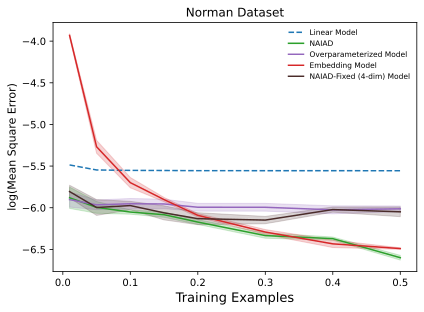

In [17]:
df = combined_results.copy() 

if 'train_frac' in df.columns:
    df = df.rename(columns={'train_frac': 'n_train'})

df['train_loss'] = np.log(df['train_loss'])
df['val_loss'] = np.log(df['val_loss'])
df['test_loss'] = np.log(df['test_loss'])

df = df[df['n_train'] <= 0.5]

plt_ax = {'val_loss': {'title': 'Test Loss',
                       'y': 'log(Mean Square Error)'}}

fig, ax = plt.subplots(1, 1, figsize = [6, 4])
y_ax = 'val_loss'

df_summary = df.groupby(['model_type', 'd_embed', 'd_pheno', 'n_train']).agg(['mean', 'std', 'count'])
df_summary = df_summary['val_loss'].reset_index()

sns.lineplot(df[df['model_type'] == 'linear'], x = 'n_train', y = y_ax, label = 'Linear Model', linestyle = '--', color = '#1f77b4', errorbar = None, ax = ax)

sns.lineplot(df[(df['model_type'] == 'both_adapt')], 
            x = 'n_train', y = y_ax, 
            label = f'NAIAD', 
            errorbar = 'se', 
            # errorbar = None,
            color = '#2ca02c',
            ax = ax)

for d_pheno in [64]:
    sns.lineplot(df[(df['model_type'] == 'pheno')], 
            x = 'n_train', y = y_ax, 
            label = f'Overparameterized Model', 
            errorbar = 'se', 
            # errorbar = None,
            color = '#9467bd',
            ax = ax)
    
for d_embed in [128]:
    sns.lineplot(df[((df['d_embed'] == d_embed) & (df['model_type'] == 'embed'))], 
                x = 'n_train', y = y_ax, 
                label = f'Embedding Model', 
                errorbar = 'se', 
                # errorbar = None, 
                color = '#d62728',
                ax = ax)

for d_combined_embed in [4]:
    sns.lineplot(df[((df['d_embed'] == d_combined_embed) & (df['model_type'] == 'both_fixed'))], 
                x = 'n_train', y = y_ax, 
                label = f'NAIAD-Fixed ({d_combined_embed}-dim) Model', 
                errorbar = 'se', 
                # errorbar = None,
                color = '#4A2C2A',
                ax = ax)

ax.set_ylabel(plt_ax[y_ax]['y'], fontsize=11)
# ax.set_xlabel('Train Frac')
ax.set_xlabel('')
# ax.set_xlim([0, 0.4])

fig.tight_layout()
ax.set_title(f'Norman Dataset')
ax.get_legend().remove()
ax.legend(fontsize=7.5, frameon=False, loc='best')
ax.set_xlabel('Training Examples', fontsize=13)
plt.show()